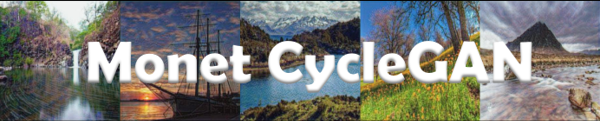<br>
Using GANs to Create Art - Monet CycleGan Project

Preface

- The project was created as part of "Advanced Deep Learning" of our deep learning specialization.
- The model takes part of the "I’m Something of a Painter Myself" Kaggle competition: https://www.kaggle.com/competitions/gan-getting-started
- The model was created using the following resources:
 - Based on our on research.
 - The knowledge we gained from Dr Moshe Butman the facultiy.
 - Information from a known research paper named "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks". The research was published by Berkeley AI Research (BAIR) laboratory, Link: https://arxiv.org/pdf/1703.10593.pdf .
 - The model was trained on RTX 4090 GPU.

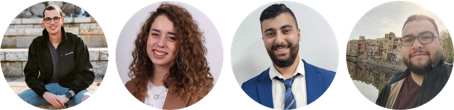<br>
Written by:
- Itamar Kirsch
- Liel Pargamentnik
- Chen Shiri
- Matan Ofri

#Part 1 - Libraries and Requirements

##1.1 Tensorflow Addons
- This addon must be installed for the "InstanceNormalization" library function.

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.4 MB/s eta 0:00:00


## 1.2 Importing the libraries

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa # Install tensorflow-addons
from tensorflow.keras.utils import plot_model #!pip install pydot
import keras as ker
import numpy as np
import os
import cv2
import glob
from keras import backend as K
from keras import initializers, layers, Input, backend, Model, losses, optimizers
from keras.layers import Conv2D, Conv2DTranspose, ReLU, Add, Activation ,Concatenate, LeakyReLU
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.initializers import RandomNormal
from keras.metrics import BinaryAccuracy
from keras.utils import register_keras_serializable
from keras.callbacks import Callback
from matplotlib import pyplot as plt
from numpy import load ,ones ,zeros ,asarray
from numpy.random import randint
from google.colab.patches import cv2_imshow
from random import random
import random as rand
from google.colab import drive
drive.mount('/content/drive')

##1.3 Hyperparameters  

In [ ]:
img_height = 320
img_width = 320
img_channels = 3
batch_size = 4
epochs = 100
learning_rate=0.0002
beta_val=0.5
img_shape = (img_width, img_height, img_channels)
num_of_resnet_blocks = 12

---
#Part 2- Implementing the blocks, Layers

##2.1 Reflection Padding Layer
We have used the code from keras documentation in order to implement the reflection padding layers. </br>
Link: https://keras.io/examples/generative/cyclegan/

##2.2 Implementing the blocks for the generator

- The **Encoder Block** is designed to downsample the input layer, extracting and compressing features through convolution, and optionally applying instance normalization for consistent feature scaling, followed by a ReLU activation for non-linearity.
- The **ResNet Block** enhances feature representation without increasing the depth or complexity significantly by applying a series of convolutions within a residual learning framework, allowing the input to be directly added to the output, which helps mitigate the vanishing gradient problem in deep networks.
- The **Decoder Block** performs the inverse operation of the encoder, upsampling the input layer and reconstructing the image or feature map dimensions through transposed convolution, with optional instance normalization and ReLU activation to maintain feature consistency and non-linearity.
- The **Resized Convolution Block** increases the spatial dimensions of the input layer through bilinear resizing and symmetric padding, followed by convolutions to refine the upscaled features, optionally applying instance normalization and ReLU activation to ensure feature normalization and introduce non-linearity.

In [ ]:
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Encoder Block
def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, activation=ker.layers.ReLU(), name='encoder'):
    enc_layer = ker.layers.Conv2D(filters, size,
                     strides=strides,
                     padding='same',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'block-{name}')(input_layer)

    if apply_instancenorm:
        enc_layer = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(enc_layer)
    enc_layer = activation(enc_layer)
    return enc_layer

# Resnet Block
def resnet_block(input_layer, size=3, strides=1, name='resnet'):
    filters = input_layer.shape[-1]
    res_layer = ReflectionPadding2D()(input_layer)
    res_layer = ker.layers.Conv2D(filters, size,
                     strides=strides,
                     padding='valid',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'block-{name}_1')(res_layer)
    res_layer = ker.layers.ReLU()(res_layer)
    res_layer = ReflectionPadding2D()(res_layer)
    res_layer = ker.layers.Conv2D(filters, size,
                     strides=strides,
                     padding='valid',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'block-{name}_2')(res_layer)
    res_layer = ker.layers.Add()([res_layer, input_layer])
    return res_layer

# Decoder Block
def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, name='decoder'):
    dec_layer = ker.layers.Conv2DTranspose(filters, size,
                              strides=strides,
                              padding='same',
                              use_bias=False,
                              kernel_initializer=conv_initializer,
                              name=f'block-{name}')(input_layer)

    if apply_instancenorm:
        dec_layer = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(dec_layer)
    dec_layer = ker.layers.ReLU()(dec_layer)
    return dec_layer

# Resized convolution Block
def resized_conv_block(input_layer, filters, size=3, strides=1, apply_instancenorm=True, name='resized_conv'):
    rescon_layer = tf.image.resize(images=input_layer, method='bilinear', size=(input_layer.shape[1]*2, input_layer.shape[2]*2))

    rescon_layer = tf.pad(rescon_layer, [[0, 0], [1, 1], [1, 1], [0, 0]], "SYMMETRIC")
    rescon_layer = ker.layers.Conv2D(filters, size, strides=strides, padding='valid', use_bias=False)(rescon_layer)
    rescon_layer = ker.layers.Conv2D(filters, size,
                     strides=strides,
                     padding='same',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'block-{name}')(rescon_layer)

    if apply_instancenorm:
        rescon_layer = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(rescon_layer)
    rescon_layer = ker.layers.ReLU()(rescon_layer)
    return rescon_layer

---
#Part 3 - Implementing the Generator and Descriminator Models

## 3.1 Generator Model

In [ ]:
def generator(height=img_height, width=img_width, channels=img_channels, resnet_blocks=num_of_resnet_blocks):
    # Input:
    inputs = ker.layers.Input(shape=[height, width, channels], name='input_image')

    # Encoder:
    # 1 - (batch_size, 256, 256, 64)
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=ker.layers.ReLU(), name='enc_1')
    # 2 - (batch_size, 128, 128, 128)
    enc_2 = encoder_block(enc_1, 128, 3, 2, apply_instancenorm=True, activation=ker.layers.ReLU(), name='enc_2')
    # 3 - (batch_size, 64, 64, 256)
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=ker.layers.ReLU(), name='enc_3')

    # Resnet:
    # The value of "resnet_blocks" times, every Layer is (batch_size, 64, 64, 256)
    res = enc_3
    for i in range(resnet_blocks):
        res = resnet_block(res, 3, 1, name=f'resnet_block_{i+1}')

    # Decoder:
    skip_con = ker.layers.Concatenate(name='enc_dec_skip_1')([res, enc_3])
    # 1 - (batch_size, 128, 128, 128)
    dec_1 = decoder_block(skip_con, 128, 3, 2, apply_instancenorm=True, name='block_1')
    skip_con = ker.layers.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2])
    # 2 - (batch_size, 256, 256, 64)
    dec_2 = decoder_block(skip_con, 64,  3, 2, apply_instancenorm=True, name='block_2')
    skip_con = ker.layers.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1])

    # Output:
    # 1 - (batch_size, 256, 256, 3)
    outputs = last = ker.layers.Conv2D(channels, 7,
                              strides=1, padding='same',
                              kernel_initializer=conv_initializer,
                              use_bias=False,
                              activation='tanh',
                              name='decoder_output_block')(skip_con)

    generator = Model(inputs, outputs)
    return generator

###Generator Model Layers Summary

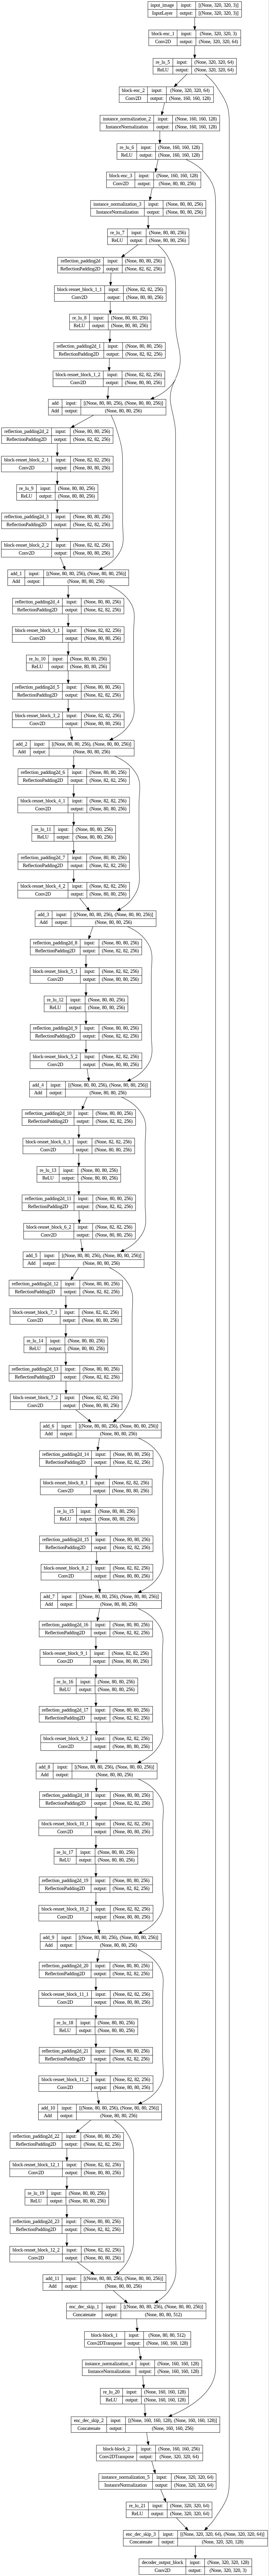

In [ ]:
plot_model(generator(), to_file='GeneratorModel.jpg', show_shapes=True)

##3.2 Discriminator Model

In [ ]:
def discriminator(height=img_height, width=img_width, channels=img_channels):
    # Input:
    inputs = ker.layers.Input(shape=[height, width, channels], name='input_image')
    inputs_patch = ker.layers.experimental.preprocessing.RandomCrop(height=70, width=70, name='input_image_patch')(inputs)

    # Encoder:
    # 1 - (batch_size, 128, 128, 64)
    x = encoder_block(inputs_patch, 64,  4, 2, apply_instancenorm=False, activation=ker.layers.LeakyReLU(0.2), name='block_1')
    # 2 - (batch_size, 64, 64, 128)
    x = encoder_block(x, 128, 4, 2, apply_instancenorm=True, activation=ker.layers.LeakyReLU(0.2), name='block_2')
    # 3 - (batch_size, 32, 32, 256)
    x = encoder_block(x, 256, 4, 2, apply_instancenorm=True, activation=ker.layers.LeakyReLU(0.2), name='block_3')
    # 4 - (batch_size, 32, 32, 512)
    x = encoder_block(x, 512, 4, 1, apply_instancenorm=True, activation=ker.layers.LeakyReLU(0.2), name='block_4')

    # Output:
    # 1 - (batch_size, 29, 29, 1)
    outputs = ker.layers.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer=conv_initializer)(x)

    discriminator = Model(inputs, outputs)
    return discriminator

###Discriminator Model Layers Summary

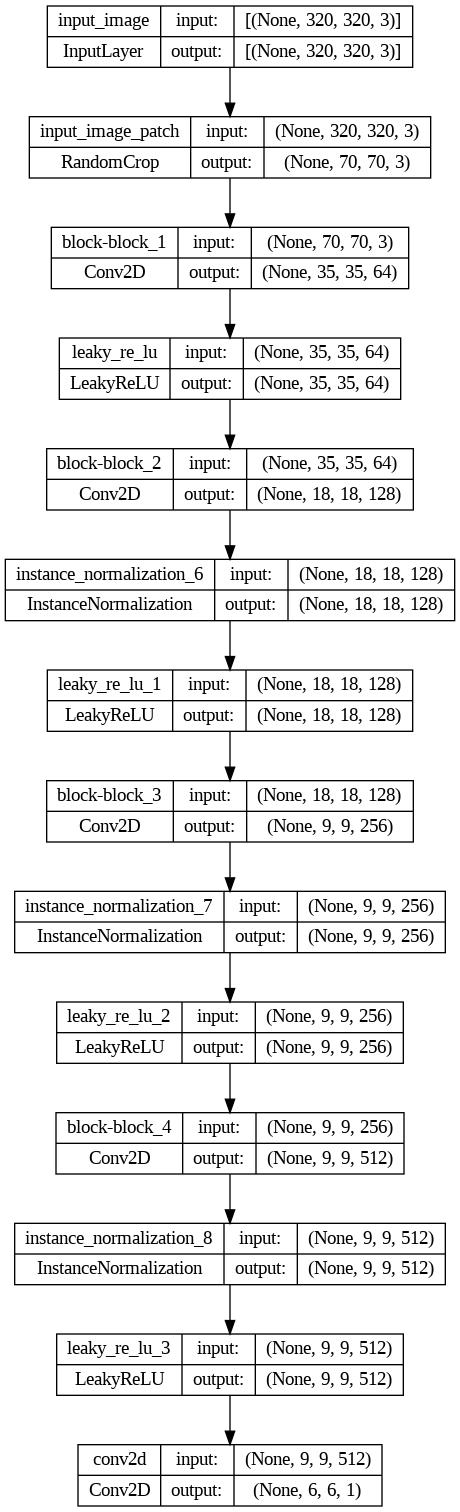

In [ ]:
plot_model(discriminator(), to_file='DiscriminatorModel.jpg', show_shapes=True)

---
#Part 4 - Data and Augmentation

##4.1 Loading the data
The model was trained on 7038 "normal" images from the competition's dataset and an additional 1072 drawings by Monet from the following repository: https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/monet2photo.zip.

In [ ]:
normal_photos = '/content/drive/Shareddrives/Monet DL Project/Data/Normal'
monet_photos = '/content/drive/Shareddrives/Monet DL Project/Data/Monet' #Delete

## 4.2 Initialization and Augmentation

In [ ]:
def monet_prep(image):
    image = tf.image.resize(image, size=[*(img_height, img_width)], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.random_crop(image, size=[*(img_height, img_width, img_channels)])
    image = tf.cast(image, dtype=tf.float32)
    image = (image / 127.5) - 1.0
    return image

def normal_prep(image):
    image = image.astype(np.float32) / 255.0
    image = (image - 0.5) * 2
    return image

datagen_normal = ImageDataGenerator(
    horizontal_flip=True,
    preprocessing_function=normal_prep,
)

datagen_monet = ImageDataGenerator(
    horizontal_flip=True,
    preprocessing_function=monet_prep,
)

normal_image_generator = datagen_normal.flow_from_directory(
    normal_photos,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

monet_image_generator = datagen_monet.flow_from_directory(
    monet_photos,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

steps = ((monet_image_generator.samples)//batch_size)

Found 7038 images belonging to 1 classes.
Found 1072 images belonging to 1 classes.


---
#Part 5 - CycleGan Model
- The model definition, written using the Keras documentation: https://keras.io/examples/generative/cyclegan/

## 5.1 Creating the model

In [ ]:
# monet_generator transforms normal photos to Monet-esque paintings:
monet_generator = generator(height=None, width=None, resnet_blocks=num_of_resnet_blocks)
# normal_generatort ransforms Monet paintings to be more like normal photos:
normal_generator = generator(height=None, width=None, resnet_blocks=num_of_resnet_blocks)
# monet_discriminator differentiates real Monet paintings and generated Monet paintings:
monet_discriminator = discriminator(height=None, width=None)
# normal_discriminator differentiates real photos and generated photos:
normal_discriminator = discriminator(height=None, width=None)

class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        normal_generator,
        monet_discriminator,
        normal_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.monet_gen = monet_generator
        self.normal_gen = normal_generator
        self.monet_disc = monet_discriminator
        self.normal_disc = normal_discriminator
        self.lambda_cycle = lambda_cycle

    # Override in Model
    def compile(
        self,
        monet_gen_optimizer,
        normal_gen_optimizer,
        monet_disc_optimizer,
        normal_disc_optimizer,
        gen_loss,
        disc_loss,
        cycle_loss, # monet -> normal -> monet || normal -> monet -> normal
        identity_loss
    ):
        super(CycleGan, self).compile()
        self.monet_gen_optimizer = monet_gen_optimizer
        self.normal_gen_optimizer = normal_gen_optimizer
        self.monet_disc_optimizer = monet_disc_optimizer
        self.normal_disc_optimizer = normal_disc_optimizer
        self.gen_loss = calc_generator_loss
        self.disc_loss = calc_discriminator_loss
        self.cycle_loss = calc_cycle_loss
        self.identity_loss = calc_identity_loss

    # Override in Model
    def train_step(self, batch_data):
        real_monet, real_normal = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Normal photo to monet and back to normal photo
            fake_monet = self.monet_gen(real_normal, training=True)
            cycled_normal = self.normal_gen(fake_monet, training=True)

            # Monet to normal photo and back to Monet
            fake_normal = self.normal_gen(real_monet, training=True)
            cycled_monet = self.monet_gen(fake_normal, training=True)

            # generating itself
            complex_monet = self.monet_gen(real_monet, training=True)
            complex_normal = self.normal_gen(real_normal, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.monet_disc(real_monet, training=True)
            disc_real_normal = self.normal_disc(real_normal, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.monet_disc(fake_monet, training=True)
            disc_fake_normal = self.normal_disc(fake_normal, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss(disc_fake_monet)
            normal_gen_loss = self.gen_loss(disc_fake_normal)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss(real_normal, cycled_normal, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss(real_monet, complex_monet, self.lambda_cycle)
            total_normal_gen_loss = normal_gen_loss + total_cycle_loss + self.identity_loss(real_normal, complex_normal, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss(disc_real_monet, disc_fake_monet)
            normal_disc_loss = self.disc_loss(disc_real_normal, disc_fake_normal)

            # Calculate the gradients for generator and discriminator
            monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.monet_gen.trainable_variables)
            self.monet_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.monet_gen.trainable_variables))

            normal_generator_gradients = tape.gradient(total_normal_gen_loss, self.normal_gen.trainable_variables)
            self.normal_gen_optimizer.apply_gradients(zip(normal_generator_gradients, self.normal_gen.trainable_variables))

            monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.monet_disc.trainable_variables)
            self.monet_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.monet_disc.trainable_variables))

            normal_discriminator_gradients = tape.gradient(normal_disc_loss, self.normal_disc.trainable_variables)
            self.normal_disc_optimizer.apply_gradients(zip(normal_discriminator_gradients, self.normal_disc.trainable_variables))


        return {'monet_gen_loss': total_monet_gen_loss,
                'photo_gen_loss': total_normal_gen_loss,
                'monet_disc_loss': monet_disc_loss,
                'photo_disc_loss': normal_disc_loss
               }

##5.2 Calculating Loss Values

About the loss:
- Discriminator Loss (calc_discriminator_loss): The discriminator's goal is to distinguish between real and generated (fake) images.
The discriminator loss consists of two parts:
 1. Real Loss: Measures how well the discriminator is able to recognize real images. It compares the discriminator's predictions for real images to an array of ones (since real images should ideally yield a score close to 1).

 2. Generated Loss: Assesses the discriminator's ability to identify generated images. It compares the discriminator's predictions for generated images to an array of zeros (since generated images should ideally yield a score close to 0).

 - The total discriminator loss is the average of these two losses, encouraging the discriminator to correctly classify real and generated images.

- Generator Loss (calc_generator_loss): The generator's objective is to create images that are indistinguishable from real images. The generator loss measures how well the generated images fool the discriminator by comparing the discriminator's predictions for generated images to an array of ones. A lower generator loss indicates that the generator is producing more realistic images.

- Cycle Loss (calc_cycle_loss): This loss is specific to CycleGANs or similar models where the goal includes not just one-way translation (e.g., normal to Monet) but also a reverse translation (e.g., Monet back to normal) to ensure consistency. The cycle loss measures the difference between an original image and a "cycled" image (an image that has been translated and then translated back). It encourages the preservation of content through the translation processes.

- Identity Loss (calc_identity_loss): This loss is used to preserve color composition between the input and output images. When an image from the target domain is fed into the generator, the identity loss measures how much the generator changes this image. The idea is that if the generator is shown an image already in the target style, it should not change the image much.

In [ ]:
def calc_discriminator_loss(real, generated):
  real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)
  generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)
  return (real_loss + generated_loss) * 0.5

def calc_generator_loss(generated):
  return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, Lambda):
  loss = tf.reduce_mean(tf.square(real_image - cycled_image))
  return Lambda * loss

def calc_identity_loss(real_image, complex_image, Lambda):
  loss = tf.reduce_mean(tf.abs(real_image - complex_image))
  return Lambda * loss * 0.5

##5.3 Optimizers and Compilation

In [ ]:
monet_generator_optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_val)
normal_generator_optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_val)

monet_discriminator_optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_val)
normal_discriminator_optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_val)

gan_model = CycleGan(monet_generator, normal_generator, monet_discriminator, normal_discriminator)
gan_model.compile(monet_gen_optimizer=monet_generator_optimizer,
                  normal_gen_optimizer=normal_generator_optimizer,
                  monet_disc_optimizer=monet_discriminator_optimizer,
                  normal_disc_optimizer=normal_discriminator_optimizer,
                  gen_loss=calc_generator_loss,
                  disc_loss=calc_identity_loss,
                  cycle_loss=calc_cycle_loss,
                  identity_loss=calc_discriminator_loss
                  )

##5.4 Reduce Linearly Learning Rate
- This function reduces the learning rate at every epoch starting from the defined epoch.

In [ ]:
selected_epoch = 45
class LinearLRScheduler(tf.keras.callbacks.Callback):
    def __init__(self, optimizer, initial_lr, epoch_to_reduce):
        super(LinearLRScheduler, self).__init__()
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.epoch_to_reduce = epoch_to_reduce

    # Override in Callback
    def on_epoch_begin(self, epoch, logs=None):
        print("current lr is",print(K.eval(self.optimizer.learning_rate)))
        if epoch >= self.epoch_to_reduce:
            new_lr = self.initial_lr * (1 - (epoch - self.epoch_to_reduce) / (self.params['epochs'] - self.epoch_to_reduce))
            tf.keras.backend.set_value(self.optimizer.learning_rate, new_lr)
            print("changed lr is",print(K.eval(self.optimizer.learning_rate)))
linear_lr_scheduler_monet_gen = LinearLRScheduler(monet_generator_optimizer, initial_lr=learning_rate, epoch_to_reduce=selected_epoch)
linear_lr_scheduler_photo_gen = LinearLRScheduler(normal_generator_optimizer, initial_lr=learning_rate, epoch_to_reduce=selected_epoch)
linear_lr_scheduler_monet_disc = LinearLRScheduler(monet_discriminator_optimizer, initial_lr=learning_rate, epoch_to_reduce=selected_epoch)
linear_lr_scheduler_photo_disc = LinearLRScheduler(normal_discriminator_optimizer, initial_lr=learning_rate, epoch_to_reduce=selected_epoch)

---
#Part 5 -Training of the model

In [ ]:
def get_from_directory(monet_generator, normal_generator, steps_per_epoch):
    while True:
        monet_images = monet_image_generator.next()[0]
        normal_images = normal_image_generator.next()[0]
        yield (monet_images, normal_images)

plotter = GANMonitor()
checkpoint_filepath = "/content/MonetModels11/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = ker.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True)

gan_model.fit(
    get_from_directory(monet_image_generator, normal_image_generator, steps),
    epochs=epochs,
    steps_per_epoch=steps,
    callbacks=[plotter, linear_lr_scheduler_monet_gen, linear_lr_scheduler_photo_gen,
               linear_lr_scheduler_monet_disc, linear_lr_scheduler_photo_disc, model_checkpoint_callback],
)

---
#Part 6 - Testing the model

##6.1 - Loading the model weights
It is possible to load the weights file that is attached to the Kaggle project.

In [ ]:
loaded_gan_model.load_weights("/content/drive/Shareddrives/Monet DL Project/Weights/res11epoch54.h5")

##6.2 - Testing the model on normal generic images

**Note:** The model was written to create images in the size of 320x320 as instructed the faculty Lecturer

In [ ]:
directory = "/content/drive/Shareddrives/Monet DL Project/Data/Normal/Normal"
all_photos = os.listdir(directory)
selected_photos = rand.sample(all_photos, 3)

for filename in selected_photos:
    srcimg = cv2.imread(os.path.join(directory, filename))
    center_x, center_y = srcimg.shape[1] // 2, srcimg.shape[0] // 2
    cropped_img = srcimg[center_y - 128:center_y + 128, center_x - 128:center_x + 128]
    img = cv2.resize(cropped_img, (img_height, img_width))
    img = img.astype('float32')
    img = (img - 127.5) / 127.5
    img = np.expand_dims(img, axis=0)
    outimg = loaded_gan_model.monet_gen(img, training=False)
    outimg = (outimg.numpy() * 127.5 + 127.5).astype(np.uint8)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Normal Image')
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Monet Image')
    plt.imshow(cv2.cvtColor(outimg[0], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

##6.3 Results:

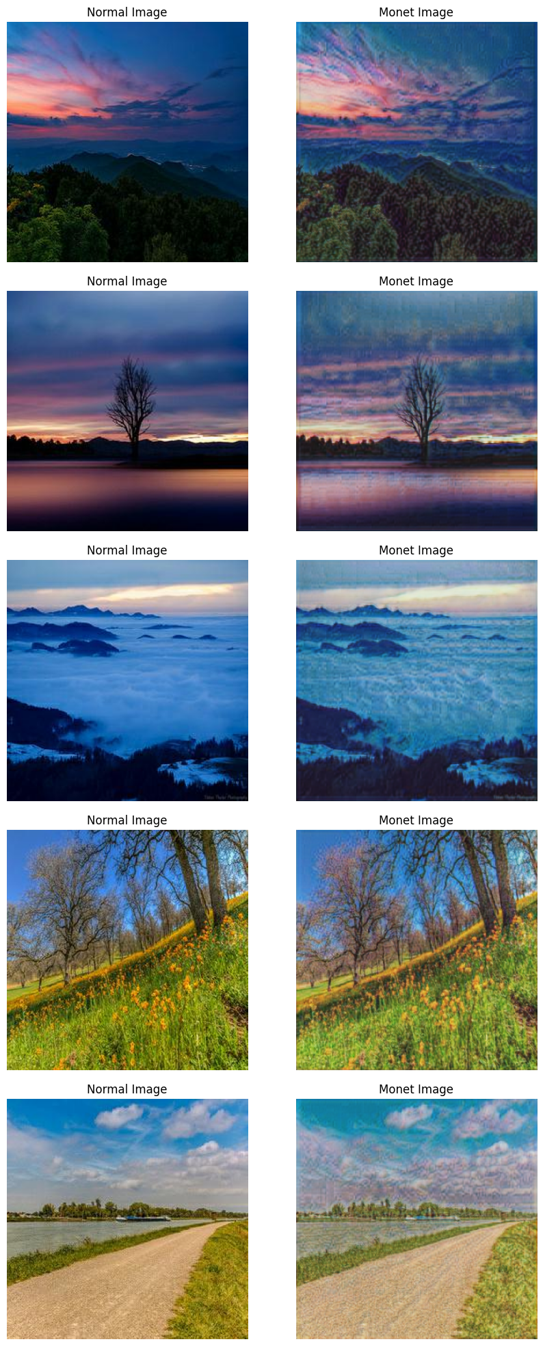